In [ ]:
import matplotlib.pyplot as plt
# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # 맥OS용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지


def show_predictions(pred_imgs, data_path="../data/dogs-vs-cats/imagenette"):
    fig, axes = plt.subplots(1, len(pred_imgs), figsize=(20, 5))
    for ax, (label, name, score) in zip(axes, pred_imgs):
        img_png = Image.open(data_path + '/' + label + "_" + name + ".jpeg")
        ax.imshow(img_png)
        ax.axis('off')
        ax.set_title(f"{name}\n{float(score):.3f}", fontsize=12)
    plt.tight_layout()
    plt.show()

In [2]:
#!gdown 10bnEC6-ZfXZFZ2mb3zoWd38TjYufanWo


(600, 600, 3)


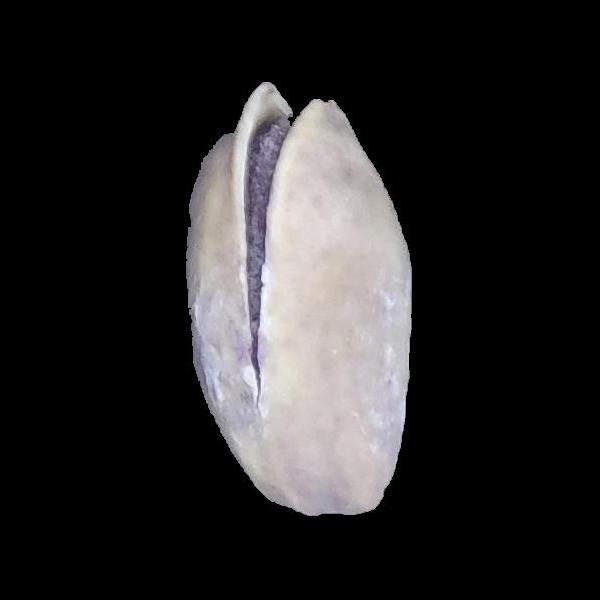

In [3]:
import numpy as np
from PIL import Image

sample_path = "../data/Pistachio_Image_Dataset/Kirmizi_Pistachio/kirmizi (1).jpg"
pistachio_sample = np.array(Image.open(sample_path))

print(pistachio_sample.shape)

display(Image.open(sample_path))

/Users/jurepi/Work/Study/hm-dl/.venv/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
2025-07-21 22:33:49.979513: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-07-21 22:33:49.979540: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-07-21 22:33:49.979547: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-07-21 22:33:49.979559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-21 22:33:49.979568: I tensorflow/core/common_runtime/pluggable_device/p

1/1 [==============================] - 3s 3s/step
[('n01950731', 'sea_slug', 0.23482394), ('n01924916', 'flatworm', 0.20674373), ('n01943899', 'conch', 0.08622373), ('n01945685', 'slug', 0.08500547), ('n01955084', 'chiton', 0.028242972)]


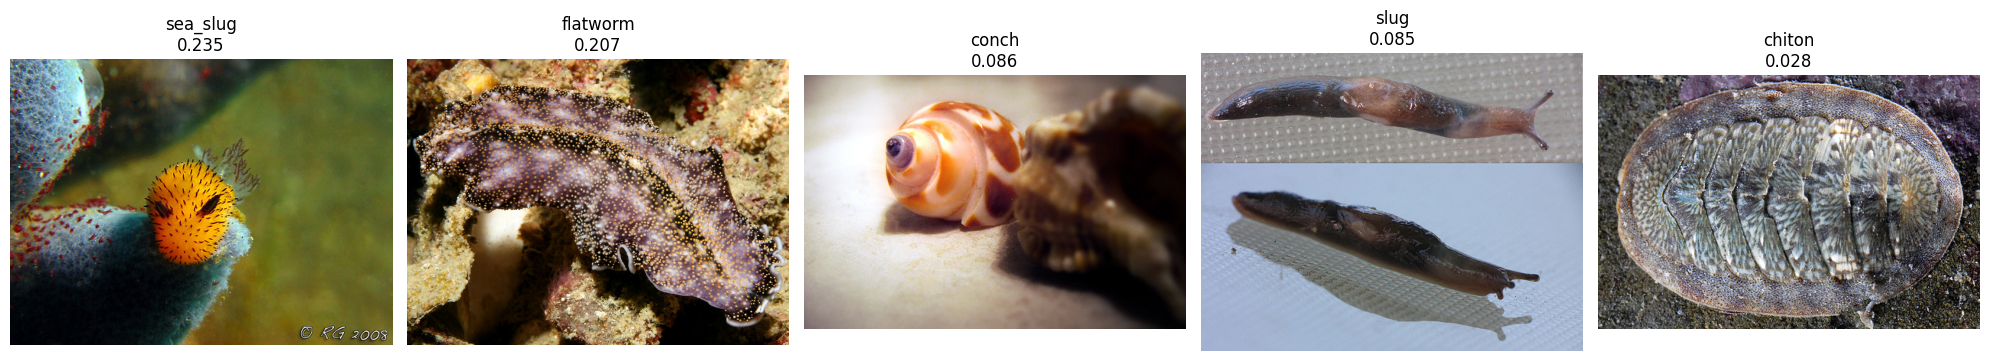

In [4]:
import tf_keras as keras
from tf_keras import layers
from tf_keras.applications import efficientnet, EfficientNetB7, EfficientNetB0
import tensorflow_hub as hub

efficientb7 = EfficientNetB7()
# efficientb7.summary()

predictions = efficientb7.predict(pistachio_sample[np.newaxis,:])
pred_imgs = efficientnet.decode_predictions(predictions)[0][:5]

print(pred_imgs)
show_predictions(pred_imgs)

In [5]:
keras_efficientnetb0_base = EfficientNetB0(include_top=False)
feature_map = keras_efficientnetb0_base(pistachio_sample[np.newaxis,:])

print(feature_map.shape)

(1, 18, 18, 1280)


In [6]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "../data/Pistachio_Image_Dataset",
    image_size=(224, 224),
    batch_size=16,
    validation_split=0.2,
    subset="both",
    seed=42
)

# train_ds = train_ds.map(lambda x, y: (keras.applications.efficientnet.preprocess_input(x), y))
# val_ds = val_ds.map(lambda x, y: (keras.applications.efficientnet.preprocess_input(x), y))


Found 2148 files belonging to 2 classes.
Using 1719 files for training.
Using 429 files for validation.


In [7]:
keras_efficientnetb0_base.trainable = False

In [8]:
# 상위 레이어 일부 해동
# keras_efficientnetb0_base.trainable = True
# fine_tune_at = 100  # 이 레이어부터 훈련

# for layer in keras_efficientnetb0_base.layers[:fine_tune_at]:
#     layer.trainable = False

In [9]:
inputs = keras.Input(shape=(224, 224, 3))

x = keras_efficientnetb0_base(inputs)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # 드롭아웃 추가

x = layers.Dense(128, activation="relu", kernel_initializer="he_normal")(x)
x = layers.Dropout(0.5)(x)  # 드롭아웃 추가

outputs = layers.Dense(1, activation="sigmoid", kernel_initializer="glorot_normal")(x)

model = keras.Model(inputs, outputs)


In [10]:
optimizer = keras.optimizers.RMSprop(learning_rate=5e-5)
# optimizer = keras.optimizers.legacy.RMSprop(learning_rate=1e-3)
# optimizer = keras.optimizers.legacy.Adam(learning_rate=1e-3)  # 학습률 20배 증가

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

hist = model.fit(train_ds, validation_data=val_ds, epochs=20)

# 4. 학습률 스케쥴링 추가
# reduce_lr = keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

# early_stop = keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=5, restore_best_weights=True)

# hist = model.fit(train_ds, validation_data=val_ds, epochs=10, 
#                 callbacks=[reduce_lr, early_stop])

Epoch 1/20
108/108 [==============================] - 7s 41ms/step - loss: 0.6786 - accuracy: 0.6027 - val_loss: 0.4746 - val_accuracy: 0.8578
Epoch 2/20
108/108 [==============================] - 3s 24ms/step - loss: 0.4981 - accuracy: 0.7580 - val_loss: 0.3433 - val_accuracy: 0.9138
Epoch 3/20
108/108 [==============================] - 3s 24ms/step - loss: 0.4000 - accuracy: 0.8336 - val_loss: 0.2719 - val_accuracy: 0.9347
Epoch 4/20
108/108 [==============================] - 3s 23ms/step - loss: 0.3332 - accuracy: 0.8610 - val_loss: 0.2292 - val_accuracy: 0.9394
Epoch 5/20
108/108 [==============================] - 3s 24ms/step - loss: 0.2885 - accuracy: 0.8854 - val_loss: 0.1989 - val_accuracy: 0.9394
Epoch 6/20
108/108 [==============================] - 3s 24ms/step - loss: 0.2565 - accuracy: 0.9069 - val_loss: 0.1780 - val_accuracy: 0.9441
Epoch 7/20
108/108 [==============================] - 3s 24ms/step - loss: 0.2327 - accuracy: 0.9081 - val_loss: 0.1631 - val_accuracy: 0.9441

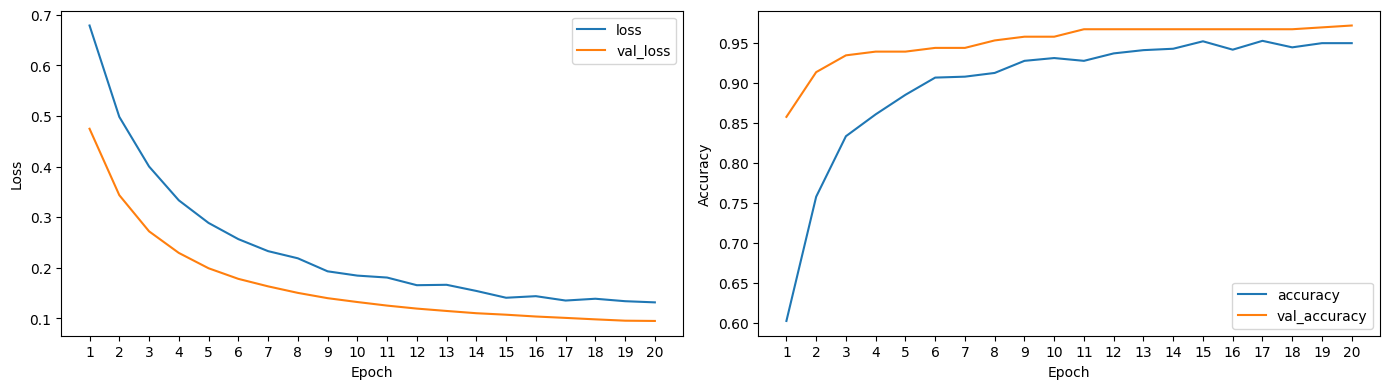

In [11]:
import matplotlib.pyplot as plt
epochs = 20
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].plot(range(1, epochs+1), hist.history["loss"], label="loss")
axs[0].plot(range(1, epochs+1), hist.history["val_loss"], label="val_loss")
axs[0].set_xticks(range(1, epochs+1))
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(range(1, epochs+1), hist.history["accuracy"], label="accuracy")
axs[1].plot(range(1, epochs+1), hist.history["val_accuracy"], label="val_accuracy")
axs[1].set_xticks(range(1, epochs+1))
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

In [26]:
import tensorflow as tf

# tf.image 사용한 전처리
def preprocess_with_tf(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return tf.expand_dims(image, 0)

def preprocess_for_efficientnet(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    
    # EfficientNet 전용 전처리 (중요!)
    image = keras.applications.efficientnet.preprocess_input(image)
    return tf.expand_dims(image, 0)

processed_image = preprocess_with_tf(sample_path)
prediction = model.predict(processed_image)
print(prediction)

sample_path = "../data/Pistachio_Image_Dataset/Siirt_Pistachio/siirt (1).jpg"
processed_image = preprocess_with_tf(sample_path)
prediction = model.predict(processed_image)
print(prediction)

1/1 [==============================] - 0s 20ms/step
[[0.35444933]]
1/1 [==============================] - 0s 19ms/step
[[0.35444933]]


In [ ]:
prediction

In [13]:
class_names = train_ds.class_names
class_names

['Kirmizi_Pistachio', 'Siirt_Pistachio']

In [14]:
# 데이터셋의 클래스 이름 확인
class_names = train_ds.class_names
#class_names = ['Kirmizi_Pistachio', 'Siirt_Pistachio']
print("클래스 이름:", class_names)
# 출력: ['Kirmizi_Pistachio', 'Siirt_Pistachio']

클래스 이름: ['Kirmizi_Pistachio', 'Siirt_Pistachio']


In [29]:
import tensorflow as tf

def interpret_prediction(prediction_value, class_names):
    """
    이진 분류 결과 해석
    - sigmoid 출력: 0~1 사이 값
    - 0.5 기준으로 클래스 결정
    """
    prob = prediction_value[0][0]  # 첫 번째 샘플의 예측값
    
    if prob > 0.5:
        predicted_class = class_names[1]  # Siirt_Pistachio
        confidence = prob
    else:
        predicted_class = class_names[0]  # Kirmizi_Pistachio  
        confidence = 1 - prob
        
    return predicted_class, confidence

# 결과 확인
sample_paths = [
    "../data/Pistachio_Image_Dataset/Kirmizi_Pistachio/kirmizi (5).jpg",
    "../data/Pistachio_Image_Dataset/Siirt_Pistachio/siirt 105.jpg"
]

import glob
#sample_paths = glob.glob("../data/Pistachio_Image_Dataset/Siirt_Pistachio/*.jpg")
#sample_paths = glob.glob("../data/Pistachio_Image_Dataset/Kirmizi_Pistachio/*.jpg")


for path in sample_paths:
    processed_image = preprocess_for_efficientnet(path)
    prediction = model.predict(processed_image, verbose=0)
    
    predicted_class, confidence = interpret_prediction(prediction, class_names)
    actual_class = path.split('/')[-2]  # 폴더 이름에서 실제 클래스 추출
    
    print(f"파일: {path.split('/')[-1]}")
    print(f"실제 클래스: {actual_class}")
    print(f"예측 클래스: {predicted_class}")
    print(f"신뢰도: {confidence:.3f}")
    print(f"원시 예측값: {prediction[0][0]:.3f}")
    print("-" * 50)

파일: kirmizi (5).jpg
실제 클래스: Kirmizi_Pistachio
예측 클래스: Kirmizi_Pistachio
신뢰도: 1.000
원시 예측값: 0.000
--------------------------------------------------
파일: siirt 105.jpg
실제 클래스: Siirt_Pistachio
예측 클래스: Siirt_Pistachio
신뢰도: 0.978
원시 예측값: 0.978
--------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # 맥OS용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

def visualize_predictions(image_paths, model, class_names):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    
    for i, path in enumerate(image_paths):
        # 이미지 로드 및 예측
        processed_image = preprocess_with_tf(path)
        prediction = model.predict(processed_image, verbose=0)
        predicted_class, confidence = interpret_prediction(prediction, class_names)
        
        # 원본 이미지 표시
        original_img = Image.open(path)
        axes[i].imshow(original_img)
        axes[i].axis('off')
        axes[i].set_title(f"예측: {predicted_class}\n신뢰도: {confidence:.3f}")
    
    plt.tight_layout()
    plt.show()

# 시각화 실행
visualize_predictions(sample_paths, model, class_names)

In [1]:
locals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['', 'locals()'],
 '_oh': {},
 '_dh': [PosixPath('/Users/jurepi/Work/Study/hm-dl/ch03')],
 'In': ['', 'locals()'],
 'Out': {},
 'get_ipython': <bound method InteractiveShell.get_ipython of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x10784b370>>,
 'exit': <IPython.core.autocall.ZMQExitAutocall at 0x1078845e0>,
 'quit': <IPython.core.autocall.ZMQExitAutocall at 0x1078845e0>,
 'open': <function io.open(file, mode='r', buffering=-1, encoding=None, errors=None, newline=None, closefd=True, opener=None)>,
 '_': '',
 '__': '',
 '___': '',
 '__vsc_ipynb_file__': '/Users/jurepi/Work/Study/hm-dl/ch03/ch03-3.ipynb',
 '_i': '',
 '_ii': '',
 '_iii': '',
 '_i1': 'locals()'}

In [19]:
# 현재 학습 상태 확인
print("=== 최종 학습 결과 ===")
if 'hist_new' in locals():
    final_train_acc = hist.history['accuracy'][-1]
    final_val_acc = hist.history['val_accuracy'][-1]
    
    print(f"훈련 정확도: {final_train_acc:.1%}")
    print(f"검증 정확도: {final_val_acc:.1%}")
    
    # 과적합 체크
    overfitting = final_train_acc - final_val_acc
    print(f"과적합 정도: {overfitting:.1%}")
    
    if overfitting > 0.1:  # 10% 이상 차이
        print("⚠️ 약간의 과적합 발생")
    else:
        print("✅ 좋은 일반화 성능")

# 베스트 검증 정확도
best_val_acc = max(hist.history['val_accuracy'])
best_epoch = hist.history['val_accuracy'].index(best_val_acc) + 1
print(f"\n최고 검증 정확도: {best_val_acc:.1%} (Epoch {best_epoch})")

=== 최종 학습 결과 ===

최고 검증 정확도: 97.2% (Epoch 20)


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import random

def test_random_samples(model, dataset, num_samples=20):
    # 1. 데이터셋에서 배치 가져오기
    sample_images = []
    sample_labels = []
    
    # 충분히 샘플을 모을 때까지 반복 (최대 1000개 제한)
    for images, labels in dataset:
        for i in range(len(images)):
            sample_images.append(images[i].numpy())
            sample_labels.append(labels[i].numpy())
            if len(sample_images) >= num_samples:
                break
        if len(sample_images) >= num_samples:
            break

    if len(sample_images) < num_samples:
        raise ValueError(f"데이터셋에서 {num_samples}개 샘플을 수집할 수 없습니다. (현재 {len(sample_images)}개)")

    # 2. 랜덤으로 num_samples개 선택 (중복 없이)
    indices = random.sample(range(len(sample_images)), num_samples)
    selected_images = [sample_images[i] for i in indices]
    selected_labels = [sample_labels[i] for i in indices]
    
    # 3. 예측 수행
    predictions = []
    for img in selected_images:
        img_batch = np.expand_dims(img, axis=0)
        pred = model.predict(img_batch, verbose=0)
        predictions.append(pred[0][0])
    
    # 4. 결과 분석
    correct = 0
    results = []
    
    for i, (pred_prob, true_label) in enumerate(zip(predictions, selected_labels)):
        predicted_class = 1 if pred_prob > 0.5 else 0
        is_correct = predicted_class == true_label
        if is_correct:
            correct += 1
            
        results.append({
            'index': i+1,
            'true_class': class_names[true_label],
            'pred_prob': pred_prob,
            'pred_class': class_names[predicted_class],
            'correct': is_correct
        })
    
    # 5. 결과 출력
    accuracy = correct / num_samples
    print(f"=== 랜덤 {num_samples}개 샘플 테스트 ===")
    print(f"정확도: {accuracy:.1%} ({correct}/{num_samples})")
    print("\n상세 결과:")
    print("-" * 80)
    
    for result in results:
        status = "✅ 정답" if result['correct'] else "❌ 오답"
        print(f"{result['index']:2d}. 실제: {result['true_class']:<16} | "
              f"예측: {result['pred_class']:<16} | "
              f"신뢰도: {result['pred_prob']:.3f} | {status}")
    
    return results, accuracy

# 실행
results, accuracy = test_random_samples(model, train_ds, 100)

=== 랜덤 100개 샘플 테스트 ===
정확도: 97.0% (97/100)

상세 결과:
--------------------------------------------------------------------------------
 1. 실제: Kirmizi_Pistachio | 예측: Kirmizi_Pistachio | 신뢰도: 0.007 | ✅ 정답
 2. 실제: Siirt_Pistachio  | 예측: Siirt_Pistachio  | 신뢰도: 0.969 | ✅ 정답
 3. 실제: Siirt_Pistachio  | 예측: Siirt_Pistachio  | 신뢰도: 0.998 | ✅ 정답
 4. 실제: Kirmizi_Pistachio | 예측: Kirmizi_Pistachio | 신뢰도: 0.011 | ✅ 정답
 5. 실제: Kirmizi_Pistachio | 예측: Kirmizi_Pistachio | 신뢰도: 0.000 | ✅ 정답
 6. 실제: Siirt_Pistachio  | 예측: Siirt_Pistachio  | 신뢰도: 0.999 | ✅ 정답
 7. 실제: Siirt_Pistachio  | 예측: Kirmizi_Pistachio | 신뢰도: 0.241 | ❌ 오답
 8. 실제: Siirt_Pistachio  | 예측: Siirt_Pistachio  | 신뢰도: 0.971 | ✅ 정답
 9. 실제: Kirmizi_Pistachio | 예측: Kirmizi_Pistachio | 신뢰도: 0.019 | ✅ 정답
10. 실제: Kirmizi_Pistachio | 예측: Kirmizi_Pistachio | 신뢰도: 0.016 | ✅ 정답
11. 실제: Kirmizi_Pistachio | 예측: Kirmizi_Pistachio | 신뢰도: 0.007 | ✅ 정답
12. 실제: Siirt_Pistachio  | 예측: Kirmizi_Pistachio | 신뢰도: 0.381 | ❌ 오답
13. 실제: Siirt_Pistachio  | 예측: Siirt_P

In [22]:
# 오답만 분석
wrong_predictions = [r for r in results if not r['correct']]
if wrong_predictions:
    print(f"\n=== 오답 분석 ({len(wrong_predictions)}개) ===")
    for wrong in wrong_predictions:
        confidence = abs(wrong['pred_prob'] - 0.5)
        print(f"• {wrong['true_class']} → {wrong['pred_class']} (확신도: {confidence:.3f})")
else:
    print("\n🎉 모든 샘플을 정확히 예측했습니다!")


🎉 모든 샘플을 정확히 예측했습니다!
